# 신용대출 심사

* 고객사는 ## 은행입니다. 신용평가 업무를 인공지능으로 전환하고자 여러분에게 모델링을 의뢰하였습니다.
* 대출업무는
    * 은행 창구에서 신청을 받고
    * 본사의 심사부서에서는 신용평가를 통해 대출 신청에 대한 승인 여부를 결정해 왔습니다.

* 현장의 요구
    * 경쟁사의 공격적인 대출상품 판매로, 본사에서는 자사 은행의 대출 실적이 줄어들고 있는 것에 부담을 느끼고 있습니다.
    * 그런데, 자사 은행에서는 신용평가 결과의 정확성에 의문을 품고 있으며, 신용평가 기준을 완화하여 가급적 대출승인 범위를 더 확대해 주기를 요구합니다. 

* 신용평가 업무를 인공지능으로 전환
    * 현장의 요구를 감안하여, 과거 사람이 하던 평가방식을 개선하고자 인공지능에 의한 예측 모델을 만들고, 정확도를 높이고자 합니다.
-----------------


* 고객에게 제공한 예측 모델
    * 여러분은 다양한 알고리즘과 튜닝을 통해 모델을 생성하였습니다.
    * 모델의 정확도가 상당히 높다고 평가 되었습니다.
    * 고객은 여러분의 결과물에 대해 기뻐하고 있습니다. 그리고 한가지 질문을 해 왔습니다.
        * **"이번에 제공한 예측 모델의 정확도가 높아 상당히 만족스럽습니다. 그런데 궁금한 점이 있습니다. 모델이 신용도를 예측하는데 중요한 요인은 무엇인가요?"**

* 본 과제를 통해서 다음을 수행합니다.
    * 다양한 알고리즘으로 모델을 만들고 성능 평가하기
    * 트리 모델로 부터 변수 중요도 확인하기
    * 그 외 모델(SVM, DL 등) 변수 중요도 확인하기
    * 선정된 모델에 대해 주요 변수의 값에 따른 예측값 변화 분석하기

![](https://www04.wellsfargomedia.com/assets/video/home-lending-shared/the-role-of-your-credit-history/the-role-of-your-credit-history_720x404.jpg)

## 1.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.backend import clear_session

### 2) 데이터 로딩

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.head()

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents,Telephone,ForeignWorker
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1,1,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1,1,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1,1,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2,2,1
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1,2,1


|	칼럼명	|	설명	|	 	|	값 의미	|
|	-----	|	-----	|	-----	|	-----	|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|
|	Telephone	|	Telephone	|	전화기 소유 여부	|	2: Yes , 1: No	|
|	ForeignWorker	|	Foreign Worker	|	외국인 근로자 여부	|	2: Yes , 1: No	|



* 데이터의 크기를 살펴봅시다.

In [3]:
data.shape

(1000, 17)

* Target 변수 조회

1    700
0    300
Name: Creditability, dtype: int64
1    0.7
0    0.3
Name: Creditability, dtype: float64


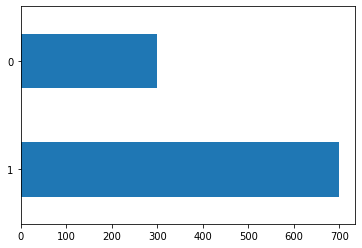

In [4]:
print(data['Creditability'].value_counts())
print(data['Creditability'].value_counts()/ data.shape[0])

data['Creditability'].value_counts().plot(kind = 'barh')
plt.show()

## 2.데이터 준비


### 1) x, y로 나누기 

In [5]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) 가변수화

In [6]:
dummy_vars = ['Employment', 'CurrentAddress', 'CreditCount', 'Dependents', 'Telephone', 'AccountBalance', 'Payment', 'Purpose', 'SexMarital', 'MostValuableAsset', 'Apartment','Occupation','ForeignWorker']


x = pd.get_dummies(x, columns = dummy_vars)
x.head()

,Duration,CreditAmount,Age,Employment_1,Employment_2,Employment_3,Employment_4,Employment_5,CurrentAddress_1,CurrentAddress_2,...,MostValuableAsset_4,Apartment_1,Apartment_2,Apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,ForeignWorker_1,ForeignWorker_2
0,24,1249,28,0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
1,9,276,22,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,18,1049,21,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,24,6419,44,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,1,0
4,12,1424,55,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0


### 3) train : validation 분할

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2022)

## 3.트리 모델의 변수 중요도
* 모델 생성
    * decision tree, random forest, xgb 알고리즘을 이용하여 각각 모델을 만드시오.
    * 알고 있는 방법을 최대한 동원하여 모델을 각각 최적화 하시오.
* 성능 및 변수 중요도 비교
    * 성능이 가장 좋은 모델을 선정하시오.
    * 성능이 가장 좋은 모델의 변수 중요도와 그렇지 않은 모델의 변수 중요도를 비교하시오.


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

In [10]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

* decision tree

In [11]:
dt = DecisionTreeClassifier()
params = {'max_depth' : range(1, 16), 'min_samples_leaf' : range(10, 101, 10)}
model1 = GridSearchCV(dt, params, cv=5, verbose=3)
model1.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END ..max_depth=1, min_samples_leaf=10;, score=0.700 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=10;, score=0.700 total time=   0.0s
[CV 3/5] END ..max_depth=1, min_samples_leaf=10;, score=0.700 total time=   0.0s
[CV 4/5] END ..max_depth=1, min_samples_leaf=10;, score=0.700 total time=   0.0s
[CV 5/5] END ..max_depth=1, min_samples_leaf=10;, score=0.700 total time=   0.0s
[CV 1/5] END ..max_depth=1, min_samples_leaf=20;, score=0.700 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=20;, score=0.700 total time=   0.0s
[CV 3/5] END ..max_depth=1, min_samples_leaf=20;, score=0.700 total time=   0.0s
[CV 4/5] END ..max_depth=1, min_samples_leaf=20;, score=0.700 total time=   0.0s
[CV 5/5] END ..max_depth=1, min_samples_leaf=20;, score=0.700 total time=   0.0s
[CV 1/5] END ..max_depth=1, min_samples_leaf=30;, score=0.700 total time=   0.0s
[CV 2/5] END ..max_depth=1, min_samples_leaf=3

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 16),
                         'min_samples_leaf': range(10, 101, 10)},
             verbose=3)

In [ ]:
model1.cv_results_

In [ ]:
pred1 = model1.predict(x_val)
print(classification_report(pred1, y_val))

              precision    recall  f1-score   support

           0       0.45      0.52      0.48        52
           1       0.82      0.78      0.80       148

    accuracy                           0.71       200
   macro avg       0.64      0.65      0.64       200
weighted avg       0.72      0.71      0.72       200



* rf

In [ ]:
rf = RandomForestClassifier()
params = {'max_depth' : range(1, 16), 'n_estimators' : range(10, 151, 10)}
model2 = GridSearchCV(rf, params, cv=5, verbose=3)
model2.fit(x_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV 1/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.1s
[CV 2/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.1s
[CV 3/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.1s
[CV 4/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.1s
[CV 5/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 1/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.1s
[CV 2/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.1s
[CV 3/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.1s
[CV 4/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.1s
[CV 5/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.1s
[CV 1/5] END ......max_depth=1, n_estimators=30;, score=0.700 total time=   0.1s
[CV 2/5] END ......max_depth=1, n_estimators=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 16),
                         'n_estimators': range(10, 151, 10)},
             verbose=3)

* xgb

In [ ]:
xgb = XGBClassifier()
params = {'max_depth' : range(1, 10), 'n_estimators' : range(10, 101, 10), 'learning_rate' : np.linspace(0.01, 0.4, 10)}
model3 = GridSearchCV(xgb, params, cv=5, verbose=3)
model3.fit(x_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=0.700 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=1, n_estimators=20;, score=0.700 total

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                         'max_depth': range(1, 10),
                         'n_estimators': range(10, 101, 10)},
             verbose=3)

* 모델 성능 비교
    * 세 모델 중 성능이 가장 좋은 모델은?

In [ ]:
pred1 = model1.predict(x_val)
print(classification_report(pred1, y_val))

              precision    recall  f1-score   support

           0       0.45      0.52      0.48        52
           1       0.82      0.78      0.80       148

    accuracy                           0.71       200
   macro avg       0.64      0.65      0.64       200
weighted avg       0.72      0.71      0.72       200



In [ ]:
pred2 = model2.predict(x_val)
print(classification_report(pred2, y_val))

              precision    recall  f1-score   support

           0       0.38      0.52      0.44        44
           1       0.85      0.76      0.80       156

    accuracy                           0.71       200
   macro avg       0.62      0.64      0.62       200
weighted avg       0.75      0.71      0.72       200



In [ ]:
pred3 = model3.predict(x_val)
print(classification_report(pred3, y_val))

              precision    recall  f1-score   support

           0       0.47      0.51      0.49        55
           1       0.81      0.78      0.79       145

    accuracy                           0.70       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.71      0.70      0.71       200



* 변수 중요도 비교 : 세 모델간 변수 중요도를 비교해 봅시다. 

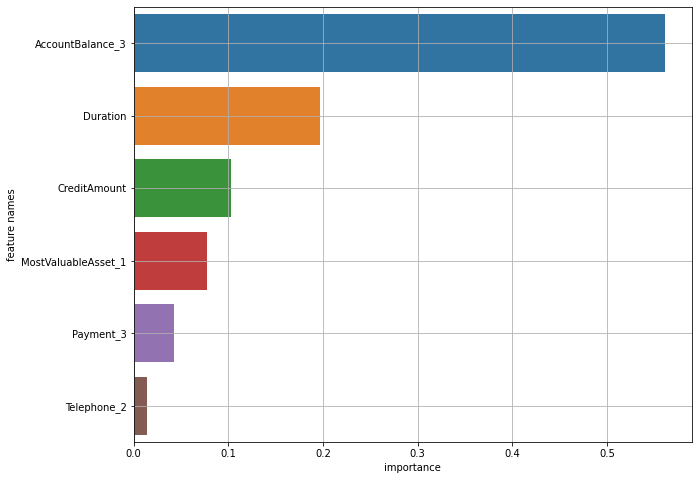

In [ ]:
result1 = plot_feature_importance(model1.best_estimator_.feature_importances_, list(x_train), topn=6)

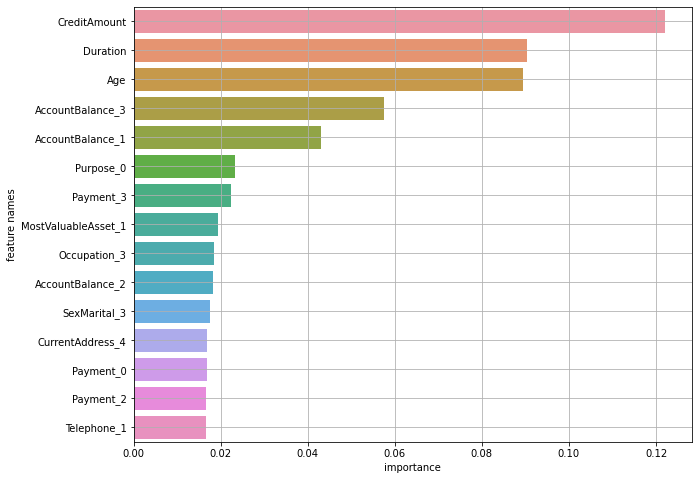

In [ ]:
result2 = plot_feature_importance(model2.best_estimator_.feature_importances_, list(x_train), topn=15)

In [ ]:
rf = RandomForestClassifier()
params = {'max_depth' : range(1, 16), 'n_estimators' : range(10, 151, 10)}
model2_1 = GridSearchCV(rf, params, cv=5, verbose=3)
model2_1.fit(x_train[result2.feature_names], y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV 1/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 2/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 3/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 4/5] END ......max_depth=1, n_estimators=10;, score=0.700 total time=   0.0s
[CV 5/5] END ......max_depth=1, n_estimators=10;, score=0.706 total time=   0.0s
[CV 1/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 2/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 3/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 4/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 5/5] END ......max_depth=1, n_estimators=20;, score=0.700 total time=   0.0s
[CV 1/5] END ......max_depth=1, n_estimators=30;, score=0.700 total time=   0.0s
[CV 2/5] END ......max_depth=1, n_estimators=

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 16),
                         'n_estimators': range(10, 151, 10)},
             verbose=3)

In [ ]:
pred2_1 = model2_1.predict(x_val[result2.feature_names])
print(classification_report(pred2_1, y_val))

              precision    recall  f1-score   support

           0       0.40      0.56      0.47        43
           1       0.86      0.77      0.81       157

    accuracy                           0.73       200
   macro avg       0.63      0.66      0.64       200
weighted avg       0.76      0.72      0.74       200



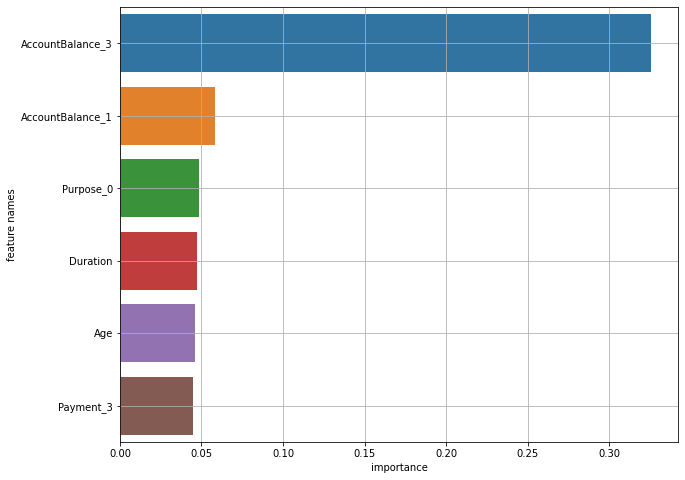

In [ ]:
result3 = plot_feature_importance(model3.best_estimator_.feature_importances_, list(x_train), topn=6)

## 4.Permutation Feature Importance
* 변수 중요도를 제공하지 않는 모델 생성
    * SVM, KNN, DL 혹은 그외 알고리즘으로 모델을 생성하시오.
    * 알고 있는 방법을 최대한 동원하여 모델을 각각 최적화 하시오.
* 성능 및 변수 중요도 비교
    * 트리 모델과 성능 비교
    * Permutation Feature Importance 를 이용하여 변수 중요도를 뽑아 봅시다.


In [ ]:
from sklearn.inspection import permutation_importance

* 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

* svm

In [ ]:
svm = SVC()
params = {'C' : range(1, 11), 'gamma' : np.linspace(0.01, 0.3, 20)}
model4 = GridSearchCV(svm, params, cv=5, verbose=3)
model4.fit(x_train_s, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END ...................C=1, gamma=0.01;, score=0.700 total time=   0.0s
[CV 2/5] END ...................C=1, gamma=0.01;, score=0.700 total time=   0.0s
[CV 3/5] END ...................C=1, gamma=0.01;, score=0.700 total time=   0.0s
[CV 4/5] END ...................C=1, gamma=0.01;, score=0.700 total time=   0.0s
[CV 5/5] END ...................C=1, gamma=0.01;, score=0.700 total time=   0.1s
[CV 1/5] END ....C=1, gamma=0.02526315789473684;, score=0.719 total time=   0.1s
[CV 2/5] END ....C=1, gamma=0.02526315789473684;, score=0.750 total time=   0.0s
[CV 3/5] END ....C=1, gamma=0.02526315789473684;, score=0.688 total time=   0.0s
[CV 4/5] END ....C=1, gamma=0.02526315789473684;, score=0.731 total time=   0.1s
[CV 5/5] END ....C=1, gamma=0.02526315789473684;, score=0.713 total time=   0.0s
[CV 1/5] END ....C=1, gamma=0.04052631578947368;, score=0.744 total time=   0.1s
[CV 2/5] END ....C=1, gamma=0.040526315789473

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': range(1, 11),
                         'gamma': array([0.01      , 0.02526316, 0.04052632, 0.05578947, 0.07105263,
       0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842,
       0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421,
       0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3       ])},
             verbose=3)

In [ ]:
model4.best_estimator_

SVC(C=7, gamma=0.02526315789473684)

In [ ]:
model4.best_score_

0.7675000000000001

* KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
params = {'n_neighbors' : range(1, 21)}
model5 = GridSearchCV(knn, params, verbose=3, cv=5)
model5.fit(x_train_s, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.700 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.669 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.644 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.694 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.719 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.688 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.662 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.637 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.619 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.650 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.719 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)}, verbose=3)

In [ ]:
model5.best_estimator_

KNeighborsClassifier(n_neighbors=17)

In [ ]:
model5.best_score_

0.73625

In [ ]:
pfi1 = permutation_importance(model5, x_val_s, y_val, n_repeats=10, scoring = 'r2', random_state=2022)

----

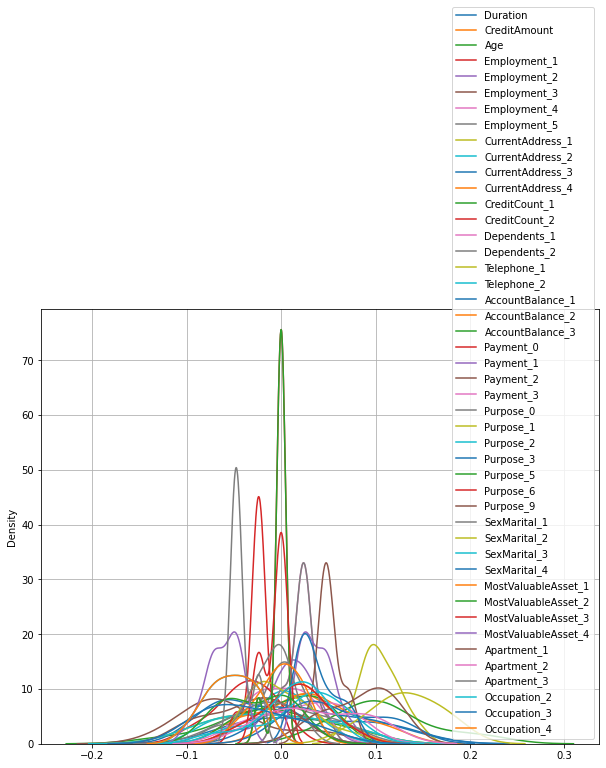

In [ ]:
plt.figure(figsize = (10,8))
for i,vars in enumerate(list(x)) :
    sns.kdeplot(pfi1.importances[i], label = vars)

plt.legend()
plt.grid()
plt.show()

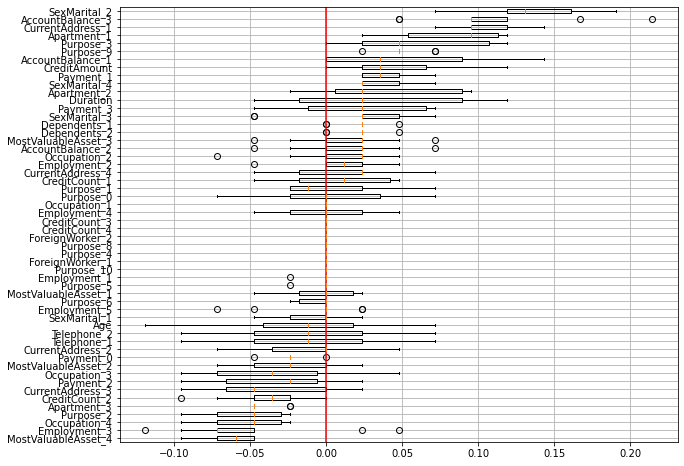

In [ ]:
sorted_idx = pfi1.importances_mean.argsort()
plt.figure(figsize = (10, 8))
plt.boxplot(pfi1.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

* 성능비교

In [ ]:
pred4 = model4.predict(x_val_s)
print(classification_report(pred4, y_val))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48        57
           1       0.79      0.78      0.78       143

    accuracy                           0.69       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.70      0.69      0.70       200



In [ ]:
pred5 = model5.predict(x_val_s)
print(classification_report(pred5, y_val))

              precision    recall  f1-score   support

           0       0.23      0.61      0.34        23
           1       0.94      0.74      0.83       177

    accuracy                           0.73       200
   macro avg       0.58      0.67      0.58       200
weighted avg       0.85      0.72      0.77       200



## 5.PDP
* 중요한 feature의 값에 따라 예측값은 어떻게 변하는지 분석해 봅시다.
    * 위 3,4번을 통해 모델을 선정하고 중요한 변수를 확인하였습니다.
    * 변수 중요도 상위 3~5개를 선정하고
    * 각 변수의 값들 변화에 따라 예측값은 어떻게 달라지는지 분석해 봅시다.
    * 두 변수의 조합으로 예측값과의 관계를 살펴보시오. 최소한 조합 2개 이상


In [14]:
from sklearn.inspection import plot_partial_dependence, partial_dependence

In [ ]:
list(x_train)

['Duration',
 'CreditAmount',
 'Age',
 'Employment_1',
 'Employment_2',
 'Employment_3',
 'Employment_4',
 'Employment_5',
 'CurrentAddress_1',
 'CurrentAddress_2',
 'CurrentAddress_3',
 'CurrentAddress_4',
 'CreditCount_1',
 'CreditCount_2',
 'CreditCount_3',
 'CreditCount_4',
 'Dependents_1',
 'Dependents_2',
 'Telephone_1',
 'Telephone_2',
 'AccountBalance_1',
 'AccountBalance_2',
 'AccountBalance_3',
 'Payment_0',
 'Payment_1',
 'Payment_2',
 'Payment_3',
 'Purpose_0',
 'Purpose_1',
 'Purpose_2',
 'Purpose_3',
 'Purpose_4',
 'Purpose_5',
 'Purpose_6',
 'Purpose_8',
 'Purpose_9',
 'Purpose_10',
 'SexMarital_1',
 'SexMarital_2',
 'SexMarital_3',
 'SexMarital_4',
 'MostValuableAsset_1',
 'MostValuableAsset_2',
 'MostValuableAsset_3',
 'MostValuableAsset_4',
 'Apartment_1',
 'Apartment_2',
 'Apartment_3',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Occupation_4',
 'ForeignWorker_1',
 'ForeignWorker_2']

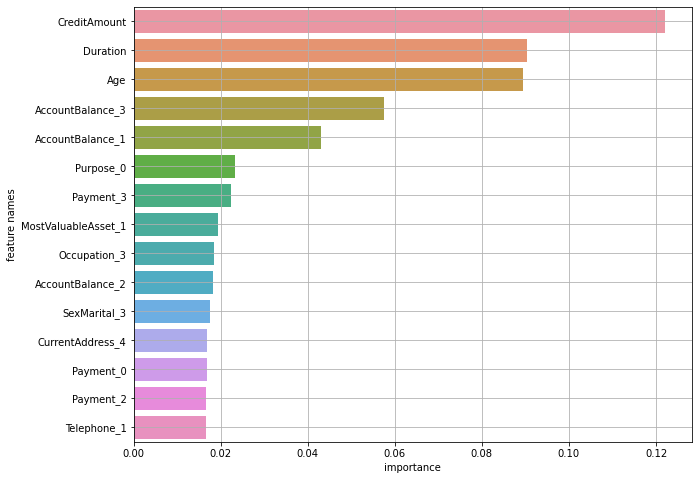

In [ ]:
result2 = plot_feature_importance(model2.best_estimator_.feature_importances_, list(x_train), topn=15)

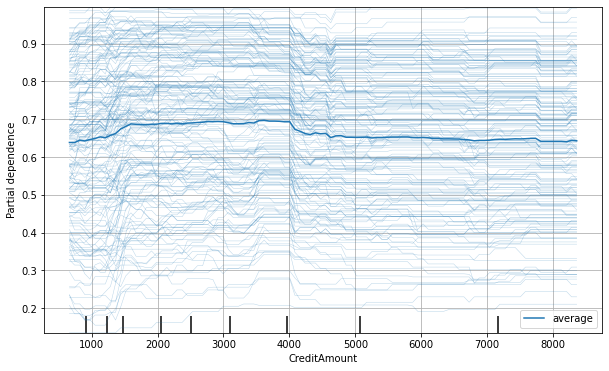

In [ ]:
var = 'CreditAmount'

plt.rcParams['figure.figsize'] = 10, 6
plot_partial_dependence(model2, features = [var], X = x_val, kind='both')
plt.grid()
plt.show()

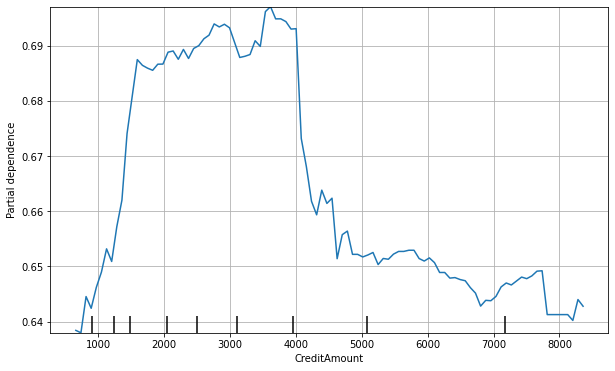

In [ ]:
var = 'CreditAmount'

plt.rcParams['figure.figsize'] = 10, 6
plot_partial_dependence(model2, features = [var], X = x_val, kind='average')
plt.grid()
plt.show()
# 약 4000달러까지 대출받은 사람은 신용도가 증가하는 추세
# 4000달러 이상은 신용도가 떨어짐

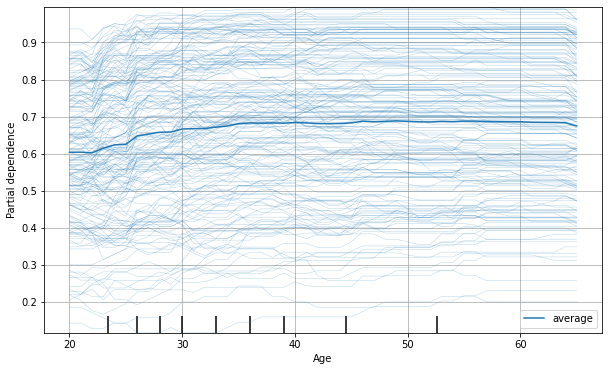

In [ ]:
var = 'Age'

plt.rcParams['figure.figsize'] = 10, 6
plot_partial_dependence(model2, features = [var], X = x_val, kind='both')
plt.grid()
plt.show()

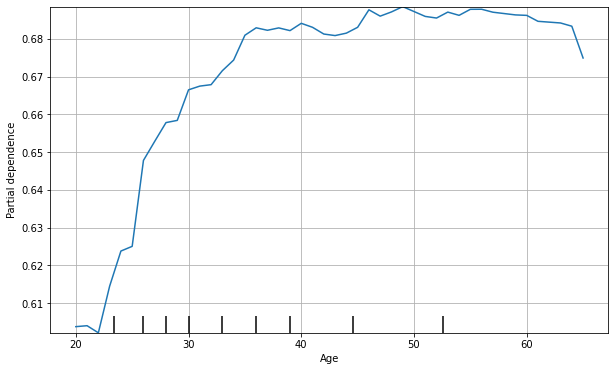

In [ ]:
var = 'Age'

plt.rcParams['figure.figsize'] = 10, 6
plot_partial_dependence(model2, features = [var], X = x_val, kind='average')
plt.grid()
plt.show()

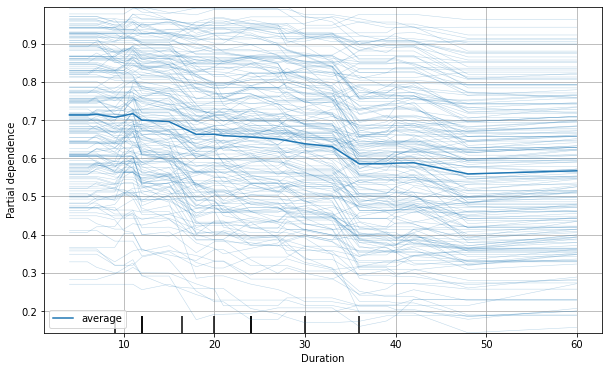

In [ ]:
var = 'Duration'

plt.rcParams['figure.figsize'] = 10, 6
plot_partial_dependence(model2, features = [var], X = x_val, kind='both')
plt.grid()
plt.show()
# 급격히 꺽이는 부분은 뭐길래 신용도가 깎일까?
# 1년, 2년, 3년 => 년단위로 대출을 보통 하기 때문에 년단위로 급격한 신용도 변동이 있겠구나 !

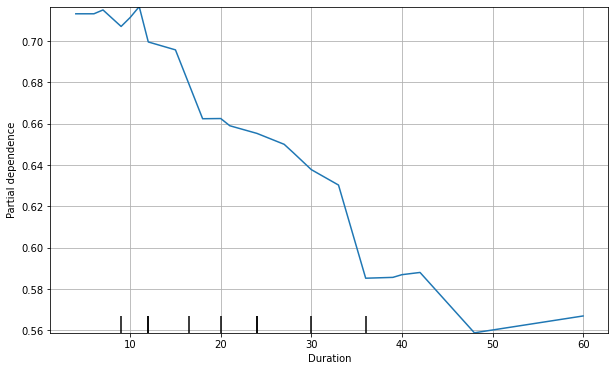

In [ ]:
var = 'Duration' # 대출신청기간

plt.rcParams['figure.figsize'] = 10, 6
plot_partial_dependence(model2, features = [var], X = x_val, kind='average')
plt.grid()
plt.show()
# 대출 신청 기간이 길어질수록 신용도가 낮아짐
# 

In [ ]:
# AccountBalance_3 : 계좌도 있고 잔고도 있음
# 0 -> 계좌도 없고 잔고도 없거나 / 계좌는 있는데 잔고는 없는 사람
# 1 -> 계좌도 있고 잔고도 있음
# 1일 수록 신용도가 높다 !(확실 - 직선그래프)
# train, val을 사용하면 차이가 존재하긴 하지만 추세는 유사함 !
# 변수중요도, pdp는 train 데이터로 살펴보는 것이 기본이지만 val로도 볼 수 있으며 결과가 유사해야 함(결과가 아예 다르다면 데이터에 문제가 있는 것 !)

In [ ]:
# 스케일된 데이터로 모델링했다면 (SVM, KNN 등) pdp를 볼 때 스케일링된 데이터에 칼럼이름을 넣어주어야 함
# 스케일링을 하면 칼럼이름은 날라가버려서 pdp로 확인하기 위해서는 칼럼이름이 필요해 !

# SVM은 마진을 기준으로 1, 0으로 값을 자르는 애임
# pdp를 사용하기 위해서는 확률값으로 계산될 수 있어야 함
# 이를 위한 옵션으로 SVC(probability = True) <- 이렇게 옵션을 주어야 함

# 딥러닝 모델은 pdp를 지원하지 않음

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

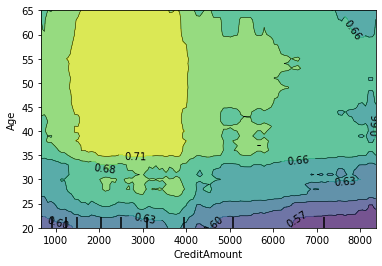

In [17]:
plot_partial_dependence(rf, features = [('CreditAmount', 'Age')], X = x_val)
plt.show()
# 나이와 대출금액을 본다면
# 대출금액이 적당하다면 나이에 상관없이 신용도가 높다.

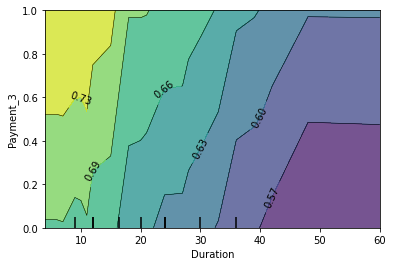

In [18]:
plot_partial_dependence(rf, features = [('Duration', 'Payment_3')], X = x_val)
plt.show()
# 은행 입장에서 신용도가 좋은 고객은 정상 대출상환 중인 고객이 더 좋은 고객 ! 돈을 벌어다주는 고객
# 가변수화한 변수는 중간에 뚝 잘라서 살펴보는 것이 좋음

In [ ]:
# 조기상환 시에도 신용도가 별로 안 높아짐
# 만기까지 다 채우고 이자 다내고 정상적으로 상환한 고객이 가장 좋은 고객..